In [13]:
!pip install huggingface_hub matplotlib pandas seaborn -q

In [14]:
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from huggingface_hub import snapshot_download

In [ ]:
REPO_ID = "VohraAK/canine-tydiqa"
LOCAL_DIR = "downloaded_checkpoints"

local_path = snapshot_download(
    repo_id=REPO_ID,
    repo_type="model",
    local_dir=LOCAL_DIR,
    allow_patterns="checkpoint-*/trainer_state.json"
)

Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 2022.24it/s]


## Step 2: Find All Checkpoints and Extract Metrics

In [16]:
# Find all checkpoint directories
checkpoint_7000 = Path(LOCAL_DIR) / "checkpoint-7000"

if checkpoint_7000.exists():
    print(f"✅ Found checkpoint-7000")
    checkpoint_dirs = [checkpoint_7000]
else:
    print("❌ checkpoint-7000 not found!")
    print("Available checkpoints:")
    all_checkpoints = sorted(
        [d for d in Path(LOCAL_DIR).glob("checkpoint-*") if d.is_dir()],
        key=lambda x: int(x.name.split("-")[1])
    )
    for cp in all_checkpoints:
        print(f"  - {cp.name}")
    checkpoint_dirs = []

✅ Found checkpoint-7000


In [17]:
def extract_metrics_from_checkpoint(checkpoint_path):

    trainer_state_path = checkpoint_path / "trainer_state.json"
    
    if not trainer_state_path.exists():
        print(f"⚠️  Warning: {trainer_state_path} not found")
        return None
    
    with open(trainer_state_path, 'r') as f:
        state = json.load(f)
    
    log_history = state.get('log_history', [])
    
    # Extract training losses
    train_losses = [
        {'step': entry.get('step'), 'loss': entry.get('loss')}
        for entry in log_history
        if 'loss' in entry
    ]
    
    # Extract evaluation metrics
    eval_metrics = [
        {
            'step': entry.get('step'),
            'exact_match': entry.get('eval_exact_match'),
            'f1': entry.get('eval_f1'),
            'edit_distance': entry.get('eval_edit_distance')
        }
        for entry in log_history
        if 'eval_exact_match' in entry or 'eval_f1' in entry
    ]
    
    return {
        'checkpoint': checkpoint_path.name,
        'global_step': state.get('global_step'),
        'train_losses': train_losses,
        'eval_metrics': eval_metrics
    }


# Extract metrics from all checkpoints
all_metrics = []
for cp_dir in checkpoint_dirs:
    metrics = extract_metrics_from_checkpoint(cp_dir)
    if metrics:
        all_metrics.append(metrics)

print(f"\n✅ Extracted metrics from {len(all_metrics)} checkpoints")


✅ Extracted metrics from 1 checkpoints


## Step 3: Combine Data from All Checkpoints

In [18]:
metrics

{'checkpoint': 'checkpoint-7000',
 'global_step': 7000,
 'train_losses': [{'step': 25, 'loss': 5.9394},
  {'step': 50, 'loss': 5.8818},
  {'step': 75, 'loss': 5.8175},
  {'step': 100, 'loss': 5.7637},
  {'step': 125, 'loss': 5.701},
  {'step': 150, 'loss': 5.6423},
  {'step': 175, 'loss': 5.591},
  {'step': 200, 'loss': 5.529},
  {'step': 225, 'loss': 5.4671},
  {'step': 250, 'loss': 5.4146},
  {'step': 275, 'loss': 5.3471},
  {'step': 300, 'loss': 5.2967},
  {'step': 325, 'loss': 5.2435},
  {'step': 350, 'loss': 5.1977},
  {'step': 375, 'loss': 5.1273},
  {'step': 400, 'loss': 5.0829},
  {'step': 425, 'loss': 5.0267},
  {'step': 450, 'loss': 4.9804},
  {'step': 475, 'loss': 4.9438},
  {'step': 500, 'loss': 4.8765},
  {'step': 525, 'loss': 4.8183},
  {'step': 550, 'loss': 4.787},
  {'step': 575, 'loss': 4.7346},
  {'step': 600, 'loss': 4.6729},
  {'step': 625, 'loss': 4.6161},
  {'step': 650, 'loss': 4.5974},
  {'step': 675, 'loss': 4.5265},
  {'step': 700, 'loss': 4.4717},
  {'step': 

In [19]:
# Combine all training losses
all_train_losses = []
for metrics in all_metrics:
    all_train_losses.extend(metrics['train_losses'])

# Combine all eval metrics
all_eval_metrics = []
for metrics in all_metrics:
    all_eval_metrics.extend(metrics['eval_metrics'])

# Convert to DataFrames
df_loss = pd.DataFrame(all_train_losses).dropna()
df_eval = pd.DataFrame(all_eval_metrics).dropna()

print("Training Loss Data:")
print(df_loss.head())
print(f"\nShape: {df_loss.shape}")

print("\n" + "="*50)
print("\nEvaluation Metrics Data:")
print(df_eval.head())
print(f"\nShape: {df_eval.shape}")

Training Loss Data:
   step    loss
0    25  5.9394
1    50  5.8818
2    75  5.8175
3   100  5.7637
4   125  5.7010

Shape: (280, 2)


Evaluation Metrics Data:
   step  exact_match        f1  edit_distance
0   500        0.484  0.486149       0.499224
1  1000        0.596  0.596000       0.604510
2  2000        0.632  0.632000       0.639023
3  2500        0.634  0.634000       0.641023
4  3000        0.638  0.638000       0.644968

Shape: (13, 4)


## Step 4: Visualize Training Progress

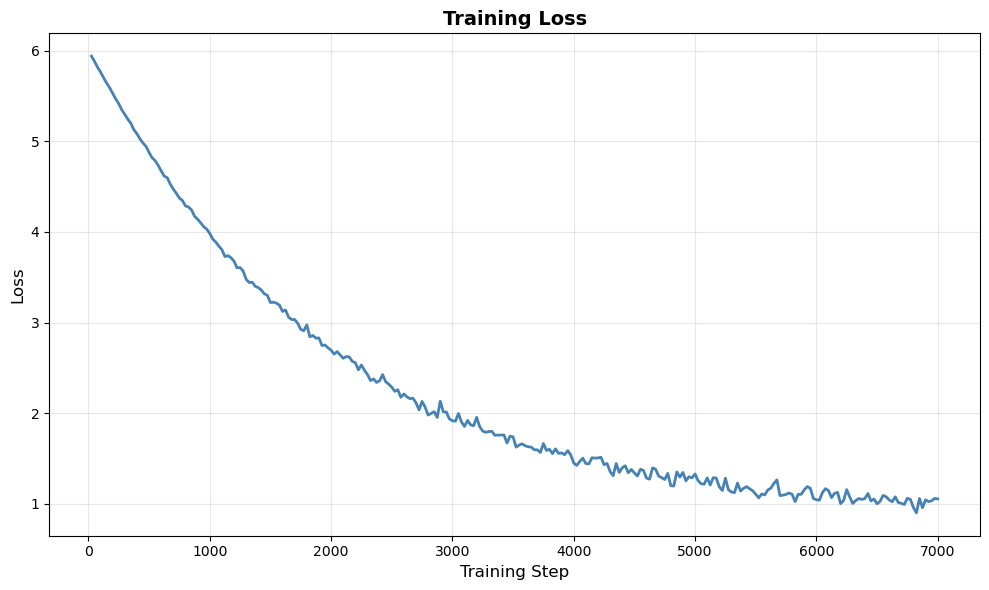

✅ Saved: loss.png


In [20]:
# Simple individual plots - Training Loss
if not df_loss.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(df_loss['step'], df_loss['loss'], linewidth=2, color='steelblue')
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training Loss', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('loss.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Saved: loss.png")
else:
    print("⚠️  No training loss data")

## Step 5: Combined Evaluation Metrics Plot

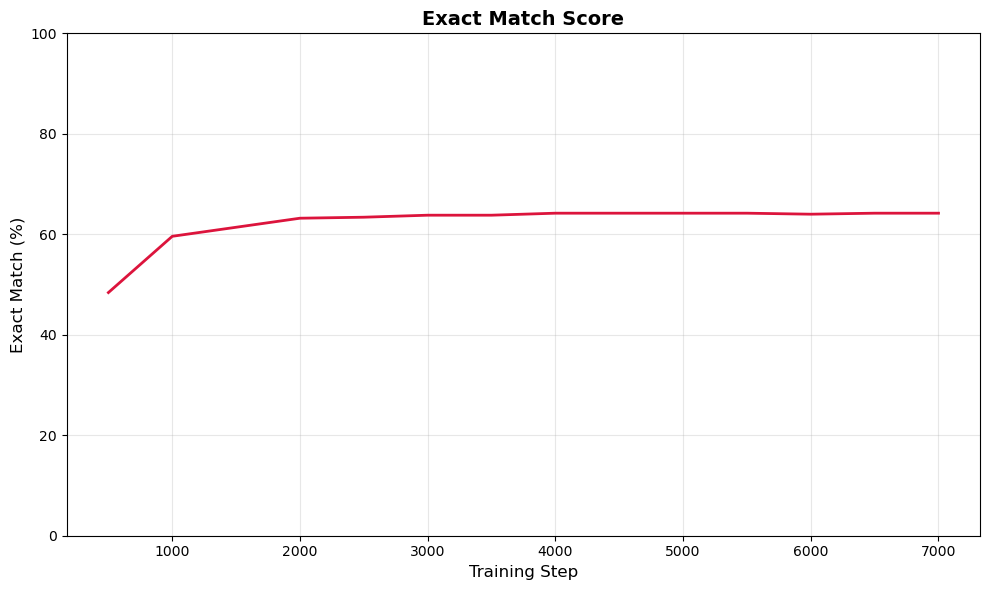

✅ Saved: exact_match.png


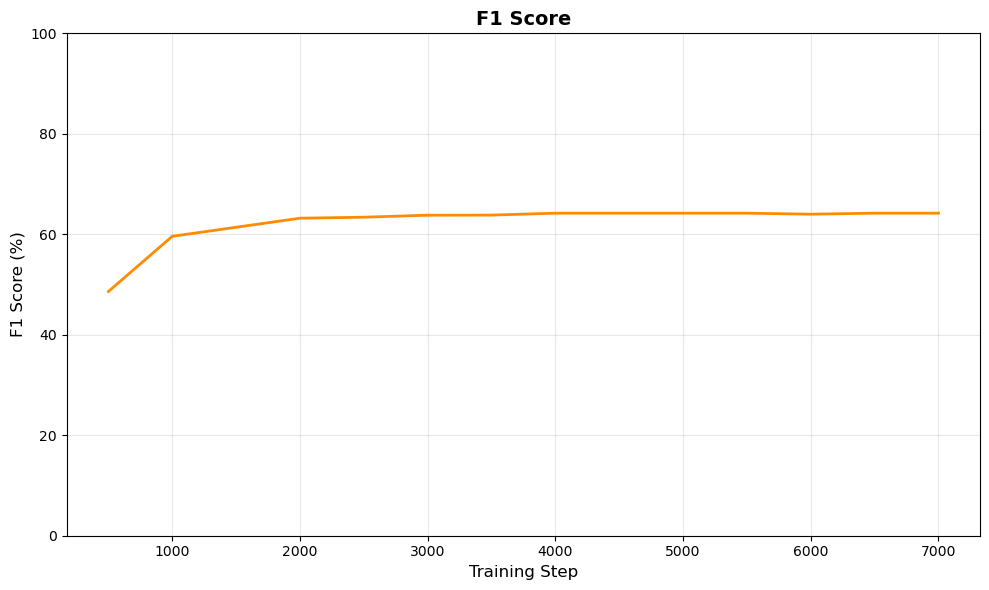

✅ Saved: f1_score.png


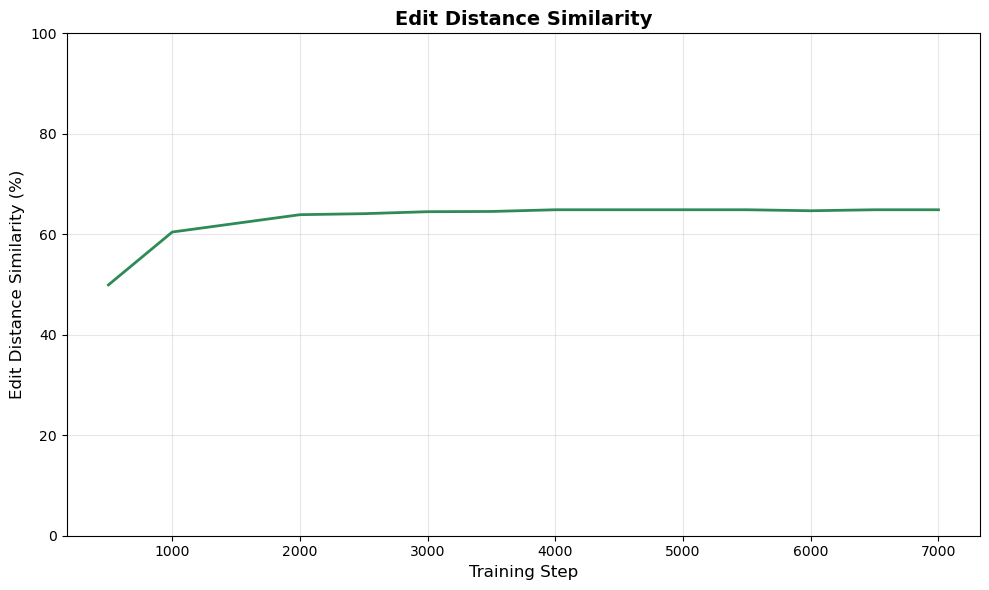

✅ Saved: edit_distance.png


In [21]:
# Simple individual plots - Exact Match
if not df_eval.empty and 'exact_match' in df_eval.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(df_eval['step'], df_eval['exact_match'] * 100, linewidth=2, color='crimson')
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Exact Match (%)', fontsize=12)
    plt.title('Exact Match Score', fontsize=14, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('exact_match.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Saved: exact_match.png")
else:
    print("⚠️  No Exact Match data")

# Simple individual plots - F1 Score
if not df_eval.empty and 'f1' in df_eval.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(df_eval['step'], df_eval['f1'] * 100, linewidth=2, color='darkorange')
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('F1 Score (%)', fontsize=12)
    plt.title('F1 Score', fontsize=14, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('f1_score.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Saved: f1_score.png")
else:
    print("⚠️  No F1 Score data")

# Simple individual plots - Edit Distance
if not df_eval.empty and 'edit_distance' in df_eval.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(df_eval['step'], df_eval['edit_distance'] * 100, linewidth=2, color='seagreen')
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Edit Distance Similarity (%)', fontsize=12)
    plt.title('Edit Distance Similarity', fontsize=14, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('edit_distance.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Saved: edit_distance.png")
else:
    print("⚠️  No Edit Distance data")

## Step 6: Summary Statistics

In [22]:
print("📊 TRAINING SUMMARY\n" + "="*60)

if not df_loss.empty:
    print("\n🔥 Training Loss:")
    print(f"  Initial Loss:  {df_loss['loss'].iloc[0]:.4f}")
    print(f"  Final Loss:    {df_loss['loss'].iloc[-1]:.4f}")
    print(f"  Best Loss:     {df_loss['loss'].min():.4f}")
    print(f"  Improvement:   {((df_loss['loss'].iloc[0] - df_loss['loss'].iloc[-1]) / df_loss['loss'].iloc[0] * 100):.2f}%")

if not df_eval.empty:
    print("\n📈 Evaluation Metrics:")
    
    if 'exact_match' in df_eval.columns:
        print(f"\n  Exact Match:")
        print(f"    Initial: {df_eval['exact_match'].iloc[0]*100:.2f}%")
        print(f"    Final:   {df_eval['exact_match'].iloc[-1]*100:.2f}%")
        print(f"    Best:    {df_eval['exact_match'].max()*100:.2f}%")
    
    if 'f1' in df_eval.columns:
        print(f"\n  F1 Score:")
        print(f"    Initial: {df_eval['f1'].iloc[0]*100:.2f}%")
        print(f"    Final:   {df_eval['f1'].iloc[-1]*100:.2f}%")
        print(f"    Best:    {df_eval['f1'].max()*100:.2f}%")
    
    if 'edit_distance' in df_eval.columns:
        print(f"\n  Edit Distance Similarity:")
        print(f"    Initial: {df_eval['edit_distance'].iloc[0]*100:.2f}%")
        print(f"    Final:   {df_eval['edit_distance'].iloc[-1]*100:.2f}%")
        print(f"    Best:    {df_eval['edit_distance'].max()*100:.2f}%")

print("\n" + "="*60)

📊 TRAINING SUMMARY

🔥 Training Loss:
  Initial Loss:  5.9394
  Final Loss:    1.0548
  Best Loss:     0.9004
  Improvement:   82.24%

📈 Evaluation Metrics:

  Exact Match:
    Initial: 48.40%
    Final:   64.20%
    Best:    64.20%

  F1 Score:
    Initial: 48.61%
    Final:   64.20%
    Best:    64.20%

  Edit Distance Similarity:
    Initial: 49.92%
    Final:   64.88%
    Best:    64.88%



## Step 7: Export Metrics to CSV

In [ ]:
# Save metrics to CSV for further analysis
if not df_loss.empty:
    df_loss.to_csv('training_losses.csv', index=False)
    print("✅ Training losses saved to 'training_losses.csv'")

if not df_eval.empty:
    df_eval.to_csv('evaluation_metrics.csv', index=False)
    print("✅ Evaluation metrics saved to 'evaluation_metrics.csv'")

✅ Training losses saved to 'training_losses.csv'
✅ Evaluation metrics saved to 'evaluation_metrics.csv'

🎉 Analysis complete!
